<a href="https://colab.research.google.com/github/Hoanava/XLA/blob/main/S1mple_ocr_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image
from google.colab import drive

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


# Chuẩn bị dữ liệu

In [2]:
drive.mount("/content/drive")
!unzip -uq "/content/drive/My Drive/data.zip" -d "./"

Mounted at /content/drive


In [3]:
data_dir = 'data'
TRAIN = 'train'
VAL = 'val'
TEST = 'sampledata'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 482 images under train
Loaded 138 images under val
Loaded 10 images under sampledata
Classes: 
['highlands', 'others', 'phuclong', 'starbucks']


# Tiện ích

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


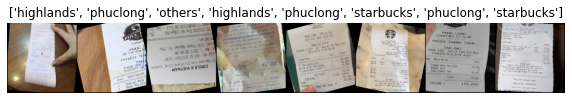

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

# Mô hình huấn luyện

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train / dataset_sizes[TRAIN]
        
        model.train(False)
        model.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Quá trình huấn luyện

In [9]:
# Tinh chỉnh chuyển đổi
# Load the pretrained model from pytorch
resnet50 = models.resnet50(pretrained=True)

# Freeze training for all layers
for param in resnet50.parameters():
    param.require_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(class_names))

if use_gpu:
    resnet50.cuda() #.cuda() will move everything to the GPU side

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Thực hiện huấn luyện
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
torch.save(resnet50.state_dict(), 'ResNet_50.pt')

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training batch 60/61
Validation batch 0/18

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.1292
Avg acc (train): 0.5643
Avg loss (val): 0.0632
Avg acc (val): 0.7826
----------

Epoch 1/20
----------
Training batch 60/61
Validation batch 0/18
Epoch 1 result: 
Avg loss (train): 0.0767
Avg acc (train): 0.7822
Avg loss (val): 0.0246
Avg acc (val): 0.9493
----------

Epoch 2/20
----------
Training batch 60/61
Validation batch 0/18
Epoch 2 result: 
Avg loss (train): 0.0635
Avg acc (train): 0.8091
Avg loss (val): 0.0217
Avg acc (val): 0.9783
----------

Epoch 3/20
----------
Training batch 60/61
Validation batch 0/18
Epoch 3 result: 
Avg loss (train): 0.0462
Avg acc (train): 0.8734
Avg loss (val): 0.0460
Avg acc (val): 0.8261
----------

Epoch 4/20
----------
Training batch 60/61
Validation batch 0/18
Epoch 4 result: 
Avg loss (train): 0.0448
Avg acc (train): 0.8693
Avg loss (val): 0.0133
Avg acc (val): 0.9565
----------

Epoch 5/20
----------
Training batch 60/61
Validation batch 0/18
Epoch 5 result: 
Avg loss (train): 0.0284
Avg acc (train): 

# Đánh giá mô hình

In [16]:
resnet50.load_state_dict(torch.load("./data/ResNet_50_20.pt"))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Ground truth:


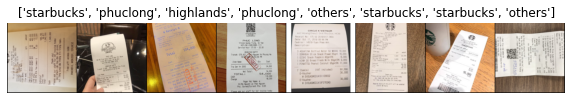

Prediction:


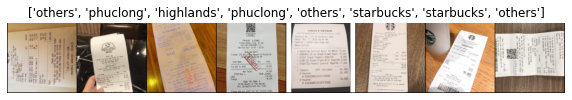

Ground truth:


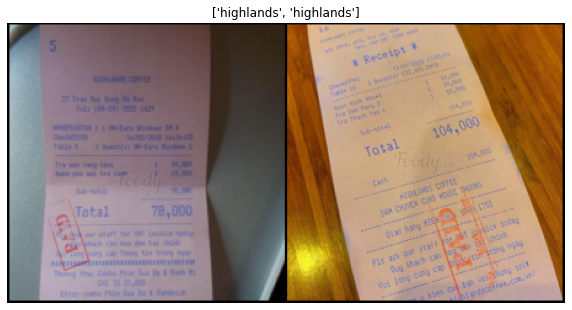

Prediction:


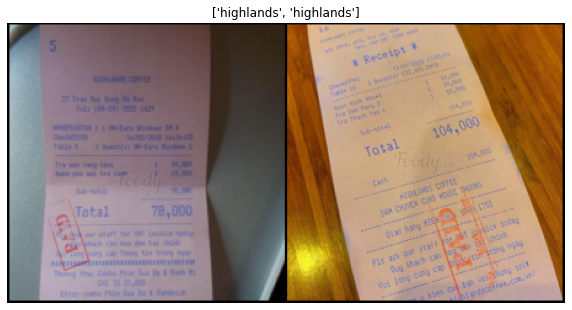

In [18]:
visualize_model(resnet50, num_images=10)